In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

from minimize import kalman_filter_smoother

In [2]:
def sample_trajectory(m0, S0, A, Q, C, R, num_points):
    
    x = np.random.multivariate_normal(mean=m0, cov=S0)
    y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
    
    x_ = np.array([x])
    y_ = np.array([y])
    
    for i in range(num_points - 1):
        
        x = np.random.multivariate_normal(mean=np.dot(A, x), cov=Q)
        y = np.random.multivariate_normal(mean=np.dot(C, x), cov=R)
        
        x_ = np.concatenate([x_[:], x[None, :]], axis=0)
        y_ = np.concatenate([y_[:], y[None, :]], axis=0)
    
    return x_, y_

In [3]:
# Dimensions of the latent and observed spaces
x_dim = 3
y_dim = 2

# Initial distribution matrices
m0 = np.array([0, 0, 0])
S0 = 1e0 * np.eye(x_dim)

# Set the random seed for comparable figures
np.random.seed(2)

# Define matrices A, Q (dynamics)
num_points = 20
t = np.linspace(0, 3, num_points)
dt = t[1] - t[0]

# Time dependent state space model matrices
A = lambda t : np.array([[1, t, t ** 2 / 2],
                         [0, 1, t],
                         [0, 0, 1]])
A = A(dt)

Q = lambda t : np.array([[t ** 5 / 20, t ** 4 / 8, t ** 3 / 6],
                         [t ** 4 / 8, t ** 3 / 3, t ** 2 / 2],
                         [t ** 3 / 6, t ** 2 / 2, t]])
Q = Q(dt)

# Define matrices C, R (data emission)
log_snr = -1.
C = np.eye(3)[:2, :]
R = np.array([[np.exp(log_snr), 0],
              [0,               0]])

# Sample points
xs, ys = sample_trajectory(m0=m0, S0=S0, A=A, Q=Q, C=C, R=R, num_points=num_points)

mf, Vf, ms, Vs, CV = kalman_filter_smoother(t=t, y=ys, log_nsr=log_snr)

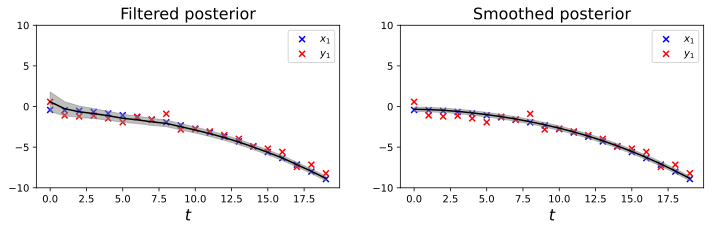

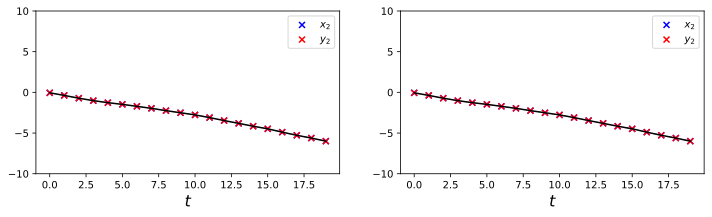

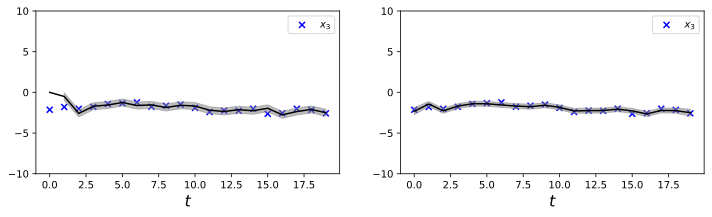

In [4]:
for i in range(3):
    
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    
    plt.plot(np.arange(num_points), mf[:, i], color='k')
    plt.scatter(np.arange(num_points), xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(np.arange(num_points), ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Filtered posterior', fontsize=16)
        
    plt.fill_between(np.arange(num_points),
                     mf[:, i] - 2 * Vf[:, i, i] ** 0.5,
                     mf[:, i] + 2 * Vf[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    
    plt.yticks(np.linspace(-10, 10, 5))
    plt.ylim(-10, 10)
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()

    plt.subplot(122)
    plt.plot(ms[:, i], color='k')
    plt.scatter(np.arange(num_points), xs[:, i], marker='x', color='blue', label=r'$x_{}$'.format(i+1))
    
    if i < 2:
        plt.scatter(np.arange(num_points), ys[:, i], marker='x', color='red', label=r'$y_{}$'.format(i+1))
    if i == 0:
        plt.title('Smoothed posterior', fontsize=16)
        
    plt.fill_between(np.arange(num_points),
                     ms[:, i] - 2 * Vs[:, i, i] ** 0.5,
                     ms[:, i] + 2 * Vs[:, i, i] ** 0.5,
                     color='gray', alpha=0.5)
    plt.yticks(np.linspace(-10, 10, 5))
    plt.xlabel(r'$t$', fontsize=16)
    plt.legend()
    
plt.show()